# Comparison with Kalman Filter

In [1]:
#@title

import jax
import itertools
import numpy as onp
import jax.numpy as np
import matplotlib.pyplot as plt
plt.style.use('matplotlibrc')
import ipywidgets as widgets

from jax.numpy.linalg import inv, pinv
from scipy.linalg import solve_discrete_are as dare
from jax import jit, grad
from IPython import display
from itertools import chain

from tqdm import tqdm


## A simple dynamical system
Defines a discrete-time linear dynamical system with Gaussian noise that mirrors 1d kinematics.

Below $\mathbf{x}_t$ is the state, $\mathbf{w}_t$ is the perturbation.

$$ \mathbf{x}_{t+1} = A\mathbf{x}_t + \mathbf{w}_t $$ 
$$ \mathbf{y}_{t+1} = C\mathbf{x}_{t+1} + \mathbf{\epsilon}_t $$

$$ A = \begin{bmatrix}
1 & 1\\
0 & 1
\end{bmatrix}$$

$$ C = \begin{bmatrix}
1 & 0\\
0 & 1
\end{bmatrix}$$

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='0'

export PATH="${PATH}:/usr/local/nvidia/bin:/usr/local/cuda/bin"

In [2]:
#import warnings
#warnings.filterwarnings('ignore')

angle = 0.2
A = np.array([[np.cos(angle), -np.sin(angle)], 
              [np.sin(angle), np.cos(angle)]])
#A = -1e-4*np.eye(2)
C = np.eye(2)#0
Q = np.array([[1, 1e-4], 
              [1e-4, 1]])/100
#Q = np.eye(2)/10
R = np.array([[1, .1], 
              [.1, 1]])/10
#R = np.eye(2)
x = np.ones(2)

100%|██████████| 100/100 [00:00<00:00, 242.07it/s]


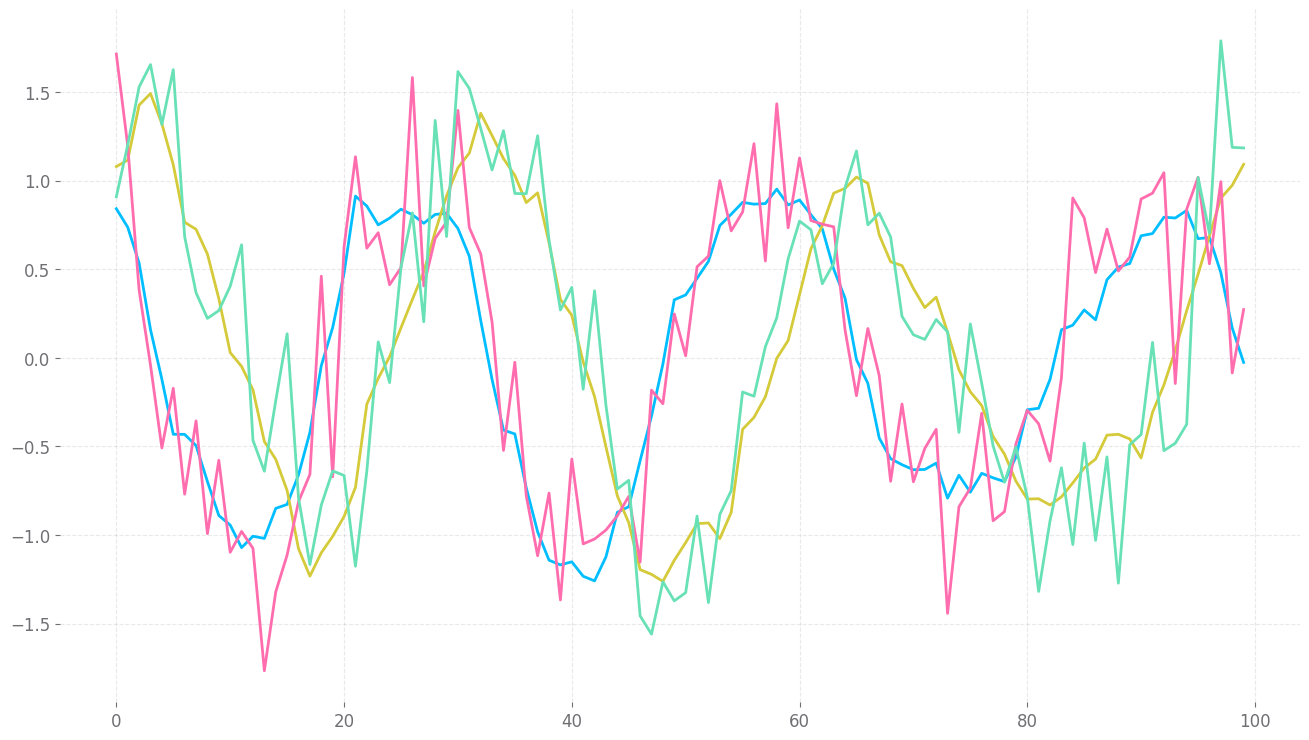

In [3]:
xs = []
ys = []
T=100
for i in tqdm(range(T)):
    randint = onp.random.randint(0, 10000)
    x = jax.random.multivariate_normal(key=jax.random.PRNGKey(randint), mean=A@x, cov=Q)
    randint = onp.random.randint(0, 10000)
    y = jax.random.multivariate_normal(key=jax.random.PRNGKey(randint), mean=C@x, cov=R)
    xs.append(x)
    ys.append(y)
xs = np.array(xs)
ys = np.array(ys)
plt.figure(figsize=(16,9))
plt.plot(xs)
plt.plot(ys)

In [10]:
import pykalman
kf = pykalman.KalmanFilter(transition_matrices=A, observation_matrices=C, 
                      transition_covariance=Q, observation_covariance=R)#.filter(ys)
kf.loglikelihood(ys)

ModuleNotFoundError: No module named 'pykalman'

In [4]:
def rprocess(x, A, Q):
    randint = onp.random.randint(0, 10000)
    return jax.random.multivariate_normal(key=jax.random.PRNGKey(randint), mean=x@A, cov=Q)

def dmeasure(y, preds, R):
    return jax.scipy.stats.multivariate_normal.logpdf(y, preds, R)

rprocess = jax.jit(rprocess)
dmeasure = jax.jit(dmeasure) #jax.jit(jax.vmap(dmeasure, in_axes=(None,0,None)))
loss_grad = (jax.vmap(jax.grad(dmeasure, argnums=1), in_axes=(None,0,None)))


        mw = np.max(weights)
        reward = mw + np.log(np.mean(np.exp(weights - mw))) # p(y_t | x_{t,1:J}, \theta)
        rewards.append(reward)
        
        if reinforce:
            log_probs = weights#[counts]
            # log_probs is shape (Np,), contains (\log p(y_t | x_{t,j}^F, \theta))_j
            baseline = np.exp(reward)
            obj += np.mean(log_probs) * np.exp(reward) #take reward to be loglik over all particles
            #obj += np.mean(log_probs * (np.exp(log_probs))) #elementwise sum reward for each particle

In [126]:
sw = True
def pfilter(angle):
    J = 100
    randint = onp.random.randint(0, 10000)
    particlesF = jax.random.multivariate_normal(key=jax.random.PRNGKey(randint), 
                                                mean=ys[0], cov=1e-3*np.eye(xs.shape[1]),
                                                shape=(J,))
    A = np.array([[np.cos(angle), -np.sin(angle)], 
              [np.sin(angle), np.cos(angle)]])
    weights = np.log(np.ones(J)/J)
    norm_weights = np.log(np.ones(J)/J)
    loglik = 0
    resamples = 0
    for t in (range(T)):
        # Get prediction particles 
        particlesP = rprocess(particlesF, A, Q)# if t>0 else particlesF
        
        # Resampling condition
        if np.max(np.exp(norm_weights))/np.min(np.exp(norm_weights)) > 1000:
            resamples += 1
            '''
            counts = jax.random.categorical(key=jax.random.PRNGKey(randint), 
                               logits=jax.lax.stop_gradient(weights),
                                shape=(J,))
            '''
            #unifs = jax.random.uniform(key=jax.random.PRNGKey(randint),
            #                           shape=norm_weights.shape)
            unifs = jax.random.uniform(key=jax.random.PRNGKey(1))+np.linspace(0,1,100)
            unifs = unifs.at[unifs>=1].set(unifs[unifs>=1]-1)
            counts = np.histogram(unifs, 
                                  bins=np.pad(np.cumsum(np.exp(norm_weights)), pad_width=(1,0)), 
                         density=False)[0].astype(int)
            print(counts)
            particlesF = particlesP[counts]
        
            # Scibior and Wood
            if sw:
                weights = weights[counts] - jax.lax.stop_gradient(weights[counts]) - np.log(J)
            else:
                weights = (np.log((1 + np.exp(weights[counts]) 
                                   - np.exp(jax.lax.stop_gradient(weights[counts])))/J))
                #log( exp(x) - exp(y) )
                #weights = (np.log(1/Np) + weights + np.log1p(-np.exp(jax.lax.stop_gradient(weights)-weights)))# - np.log(Np)
        else:
            particlesF = particlesP
        
        weights += dmeasure(ys[t], particlesP, R) #shape (Np,)
        
        mw = np.max(weights)
        loglik_t = mw + np.log(np.sum(np.exp(weights - mw))) # p(y_t | x_{t,1:J}, \theta)
        norm_weights = weights - loglik_t
        loglik += loglik_t
    print(resamples)
    return loglik

pfilter(0.2)

[ 0  0  1  0  0  0  0  0  2  0  0  0  0  0  1  3  0  0  0  1  1  0  0  0
 70  0  1  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  5  0  0
  0  0  0  3  1  2  1  2  0  0  0  0  0  1  0  0  0  0  0  0  0  1  0  0
  0  0  0  1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 99  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0 100   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   

Array(-3459.414, dtype=float32)

In [40]:
verbose=False
loglik=True
method='agg'
obj1 = np.mean(np.array([jax.grad(pfilter, argnums=0)(angle) for i in range(10)]),0) #compare against pfilter and kalmanfilter in pomp
#loglik=False
#method='disagg'
obj2 = np.mean(np.array([jax.grad(pfilter, argnums=0)(angle) for i in range(10)]),0)
print(obj1)
print(obj2)

-19.404648
-21.099752


In [41]:
#Variance dependence on horizon
Told = T
stds = []
sw = True
for i in tqdm([10,20,30,40,50]):
    T = i
    #stds.append(np.std(np.array([jax.grad(pfilter, argnums=0)(A) for i in range(10)]),0))
    stds.append(np.std(np.array([jax.grad(pfilter, argnums=0)(angle) for i in range(10)])))
T = Told
stdsw = np.copy(np.array(stds))

Told = T
stds = []
sw = False
for i in tqdm([10,20,30,40,50]):
    T = i
    #stds.append(np.std(np.array([jax.grad(pfilter, argnums=0)(A) for i in range(10)]),0))
    stds.append(np.std(np.array([jax.grad(pfilter, argnums=0)(angle) for i in range(10)])))
T = Told
stds = np.copy(np.array(stds))

100%|██████████| 5/5 [00:11<00:00,  2.28s/it]


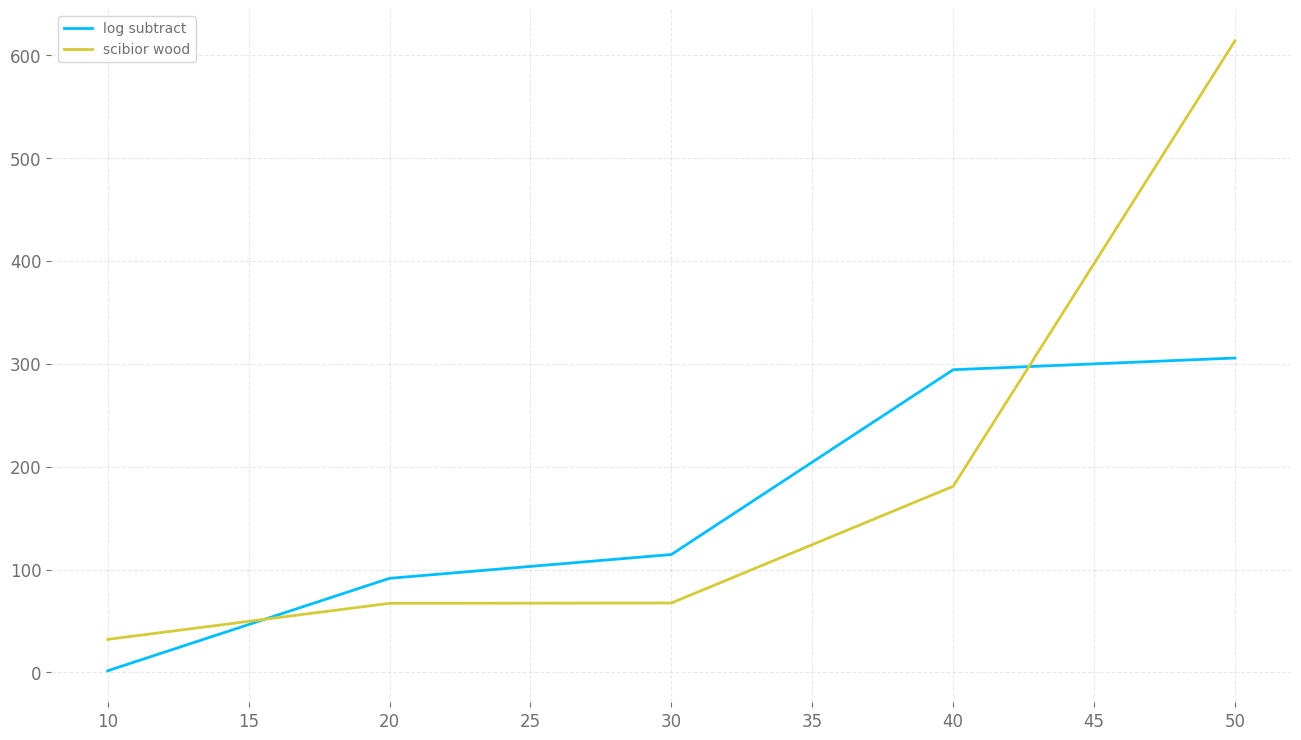

In [22]:
#plt.plot(np.array(stds).reshape(len(stds),4))
plt.figure(figsize=(16,9))
plt.plot([10,20,30,40,50],(stds)**2, label='log subtract')
plt.plot([10,20,30,40,50],(stdsw/30)**2, label='scibior wood')
plt.legend()

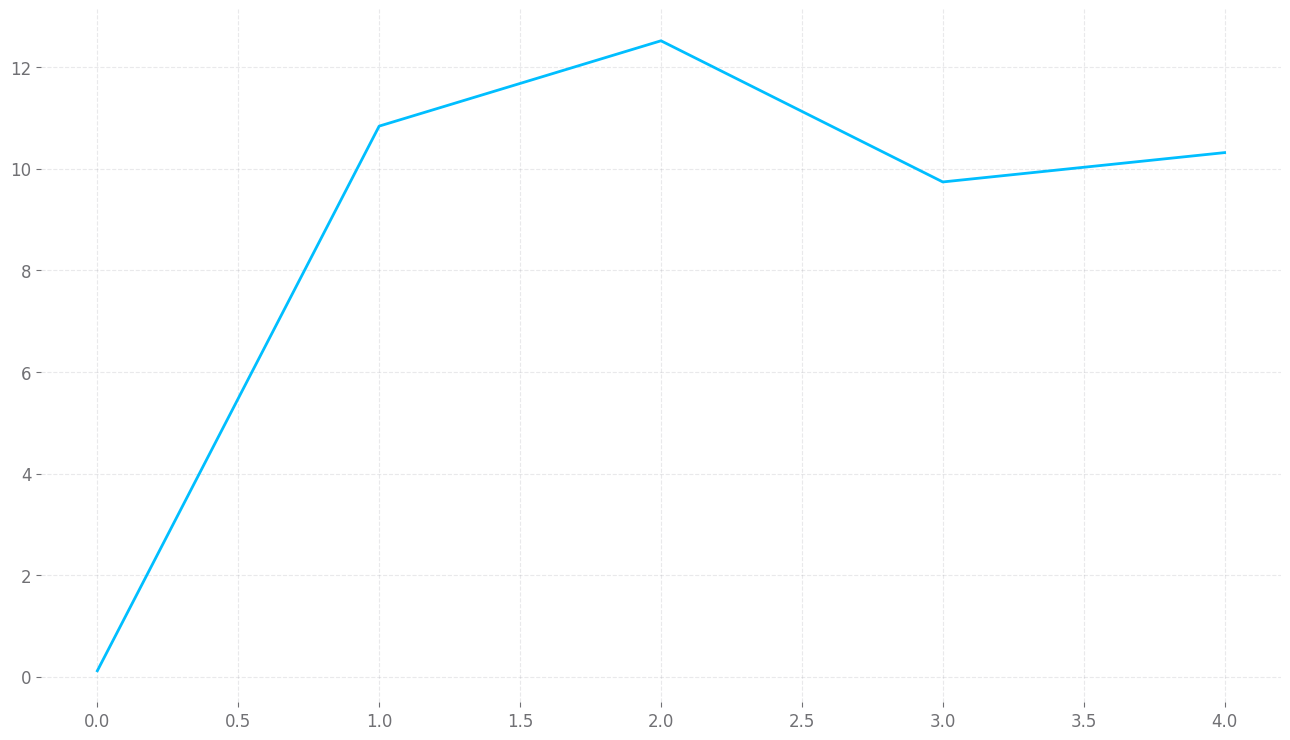

In [42]:
#plt.plot(np.array(stds).reshape(len(stds),4))
plt.figure(figsize=(16,9))
plt.plot(np.array(stds))

In [62]:
pfilter(0.4)

Array(-460.51703, dtype=float32)

In [58]:
import copy
verbose=False
sw = True
print(A)
Acopy = 0.5*np.ones((2,2))#copy.deepcopy(A)
Acopies = []
grads = []
hesses = []
angle_hat = 0.1
for i in tqdm(range(10)):
    Acopies.append(angle_hat)
    print(pfilter(angle_hat))
    grad = jax.grad(pfilter, argnums=0)(angle_hat)
    hess = jax.hessian(pfilter, argnums=0)(angle_hat)
    grads.append(grad)
    hesses.append(hess)
    if i%1==0:
        print(angle_hat)
        #print(grad)
    angle_hat = angle_hat + (1/hess)*grad#np.clip(grad,-5,5)

[[ 0.9800666  -0.19866933]
 [ 0.19866933  0.9800666 ]]


  0%|          | 0/10 [00:00<?, ?it/s]

-460.51703


 10%|█         | 1/10 [00:01<00:17,  1.93s/it]

0.1
-460.51703


 20%|██        | 2/10 [00:03<00:16,  2.01s/it]

0.086556904
-460.51703


 30%|███       | 3/10 [00:05<00:13,  1.98s/it]

0.1601564
-460.51703


 40%|████      | 4/10 [00:07<00:11,  1.97s/it]

0.2932936
-460.51703


 50%|█████     | 5/10 [00:09<00:09,  1.96s/it]

0.30635682
-460.51703


 60%|██████    | 6/10 [00:11<00:07,  2.00s/it]

0.29575104
-460.51703


 70%|███████   | 7/10 [00:13<00:05,  1.98s/it]

0.28457534
-460.51703


 70%|███████   | 7/10 [00:14<00:06,  2.07s/it]
Exception ignored in: <function _xla_gc_callback at 0x7fcb0829edd0>
Traceback (most recent call last):
  File "/home/kevin/anaconda3/envs/jax/lib/python3.10/site-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [31]:
grad

Array([[nan, nan],
       [nan, nan]], dtype=float32)

<Figure size 1600x900 with 0 Axes>

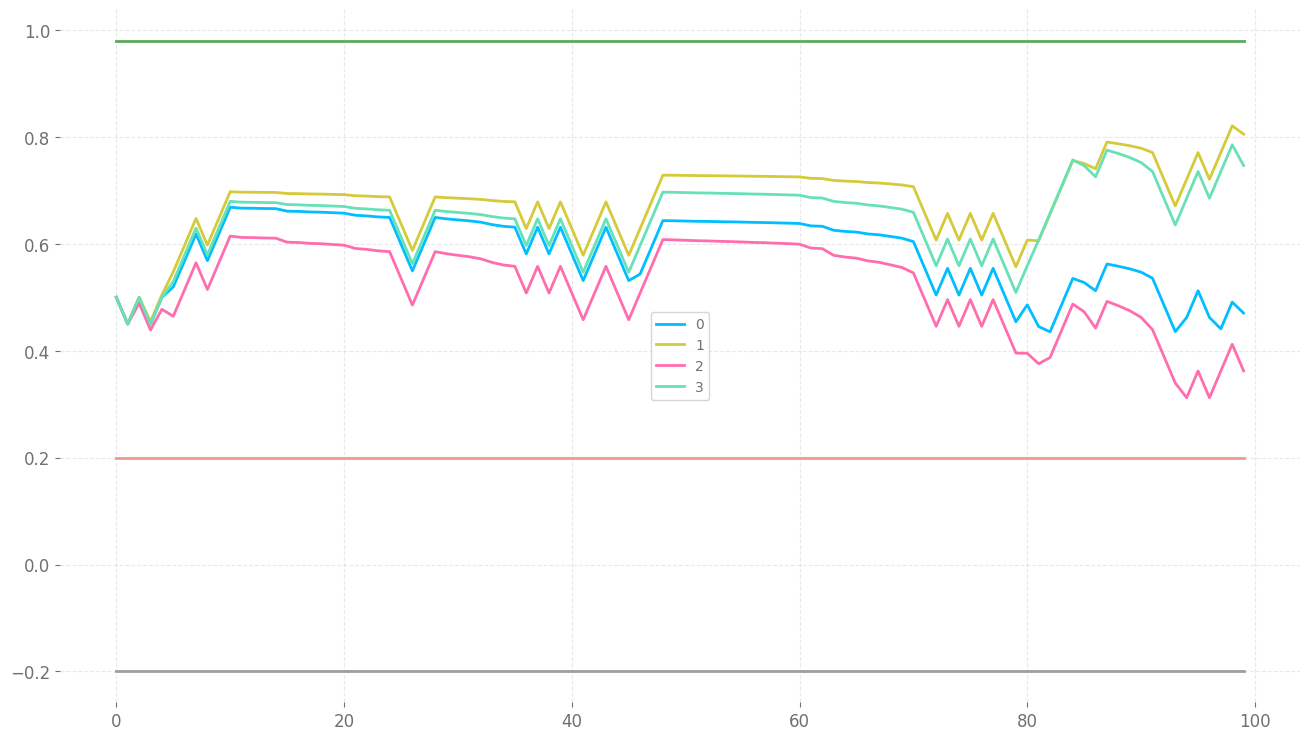

In [27]:
import pandas as pd
plt.figure(figsize=(16,9))
pd.DataFrame(np.array(Acopies).reshape(len(Acopies), Acopies[0].shape[1]**2)).plot(figsize=(16,9))
plt.plot(np.array([A.flatten() for i in range(100)]))

<Figure size 1152x648 with 0 Axes>

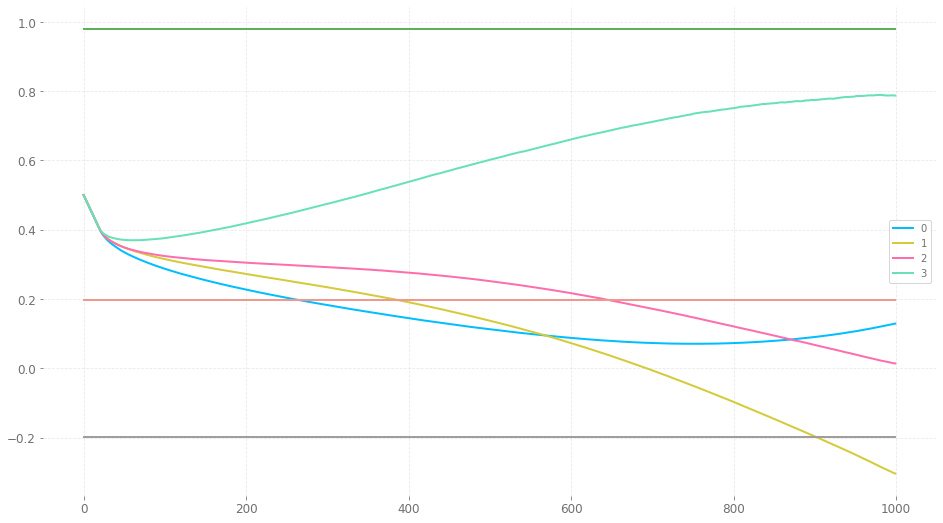

In [864]:
import pandas as pd
plt.figure(figsize=(16,9))
pd.DataFrame(np.array(Acopies).reshape(len(Acopies), Acopies[0].shape[1]**2)).plot(figsize=(16,9))
plt.plot(np.array([A.flatten() for i in range(1000)]))

<AxesSubplot:>

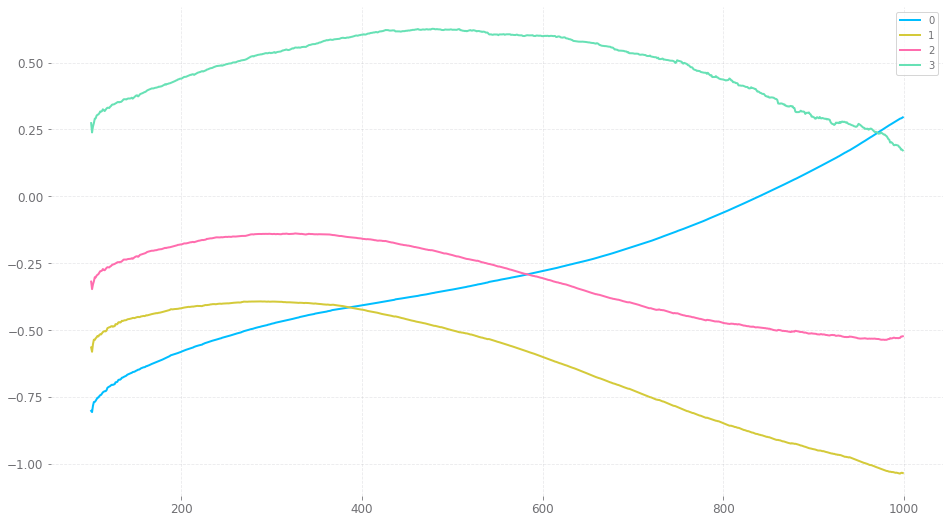

In [866]:
import pandas as pd
pd.DataFrame(np.array(grads).reshape(len(grads), grads[0].shape[1]**2))[100:].ewm(100).mean().plot(figsize=(16,9))

<Axes: >

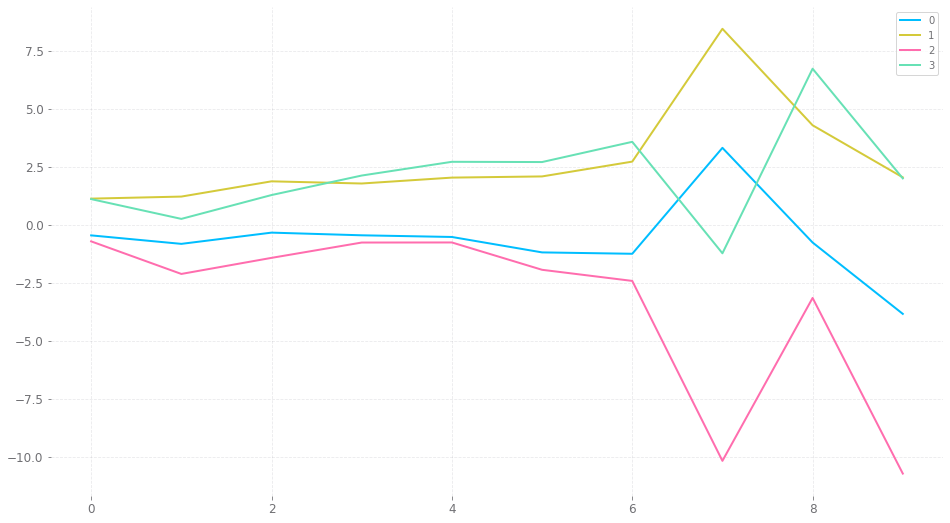

In [144]:
import pandas as pd
pd.DataFrame(np.array(grads).reshape(len(grads), grads[0].shape[1]**2)).plot(figsize=(16,9))

<AxesSubplot:>

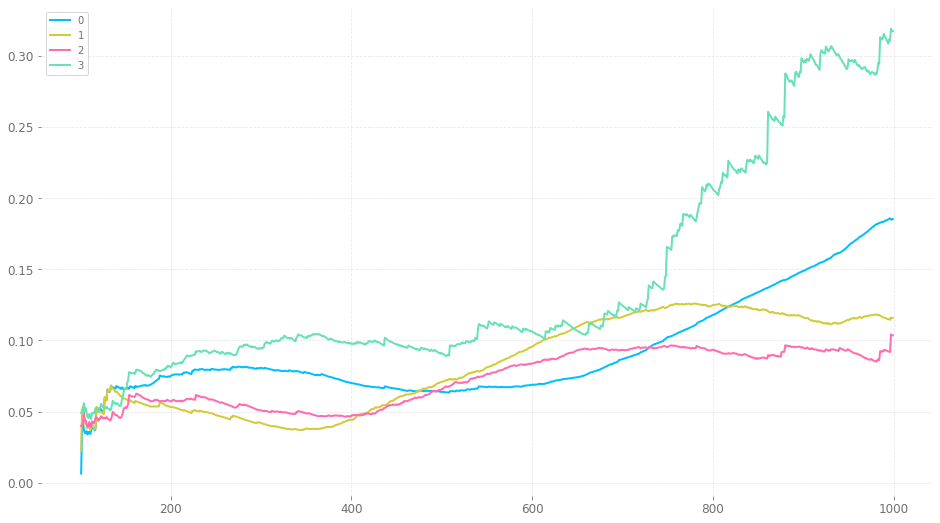

In [869]:
import pandas as pd
pd.DataFrame(np.array(grads).reshape(len(grads), grads[0].shape[1]**2))[100:].ewm(100).std().plot(figsize=(16,9))

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 298.75it/s]


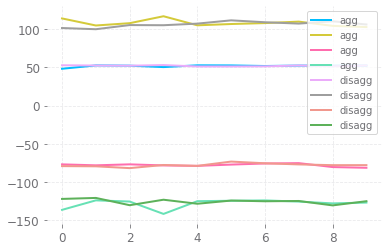

In [654]:
verbose=False
loglik=True
method='agg'
plt.plot(np.array([jax.grad(pfilter, argnums=0)(A) for i in range(10)]).reshape(10,2*2), label='agg')
method='disagg'
plt.plot(np.array([jax.grad(pfilter, argnums=0)(A) for i in range(10)]).reshape(10,2*2), label='disagg')
plt.legend()
plt.show()

In [669]:
# Set a step size for finite differences calculations
#method='disagg'
verbose=False

A_nums = []
A_grads = []
for i in range(10):
    eps = 1e-2
    randint = onp.random.randint(0, 10000)
    key=jax.random.PRNGKey(randint)

    # Check W_grad with finite differences in a random direction
    key, subkey = jax.random.split(key)
    vec = jax.random.normal(subkey, A.shape)
    unitvec = A #vec / np.sqrt(np.vdot(vec, vec))
    loglik=True
    A_nums.append((pfilter(A + eps / 2. * unitvec) - pfilter(A - eps / 2. * unitvec)) / (eps))
    loglik=True
    A_grads.append(np.vdot(grad(pfilter,argnums=0)(A), unitvec))

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 293.88it/s]


In [ ]:
plt.plot(np.array(A_nums))
plt.plot(np.array(A_grads))

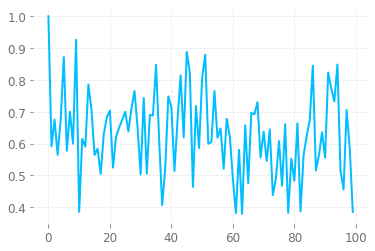

In [359]:
plt.plot(np.array(A_grads)/np.max(np.abs(np.array(A_grads))))

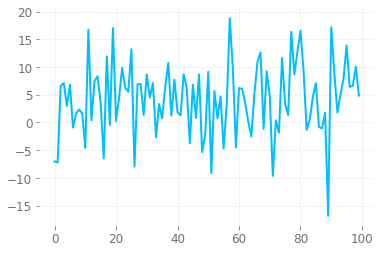

In [348]:
plt.plot(np.array(A_nums)/750 - np.array(A_grads))

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape).cuda()
    return -Variable(torch.log(-torch.log(U + eps) + eps))

def gumbel_softmax_sample(logits, temperature):
    #y = logits + sample_gumbel(logits.size())
    y = F.log_softmax(logits, dim=-1) + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature):
    """
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    return (y_hard - y).detach() + y #equivalent to rsample

import math
print(gumbel_softmax(Variable(torch.FloatTensor([[math.log(0.1), math.log(0.4), math.log(0.3), math.log(0.2)]] * 20000)),     
                     0.8).sum(dim=0))

In [ ]:
#not necessary to do this
z, probs = g_s_net(input, temp)
sample = torch.mm(z, torch.FloatTensor(some_categorical_list))
loss = probs * z

In [27]:
import numpy as np
x = np.random.uniform(-1,1,100000000)
y = np.exp(x)
X = np.vstack([np.ones(100000000),
           x, x**2]).T

In [28]:
import sklearn.linear_model
sklearn.linear_model.LinearRegression(fit_intercept=False).fit(X, y).coef_

array([0.99628735, 1.10364072, 0.53673719])

In [26]:
H = np.zeros((3,3))
for i in range(3):
    for j in range(3):
        H[i,j] = (1**(i+j+1) - (-1)**(i+j+1))/ (i+j+1)
H

array([[2.        , 0.        , 0.66666667],
       [0.        , 0.66666667, 0.        ],
       [0.66666667, 0.        , 0.4       ]])